In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [18]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from modules.plotting_functions import periodic_table_heatmap
from modules.function import get_elem_count,pymatgen_comp, get_number_of_components, get_comp_count_over_bins, alt_read_gfa_dataset

# Trends in dataset visualized

In [17]:
hardness_file_path = 'dataset/hardness.csv'
yield_str_file_path = 'dataset/yield_strength.csv'
phase_file_path = 'Files_from_GTDL_paper/gao_data.txt'
fig_location = 'figures'
hardness_df = pd.read_csv(hardness_file_path)
yield_str_df = pd.read_csv(yield_str_file_path)


## Periodic table heatmaps of elements in the GFA and HEA phase dataset

<module 'matplotlib.pyplot' from '/noether/s0/aqd5773/anaconda3/envs/representations/lib/python3.10/site-packages/matplotlib/pyplot.py'>

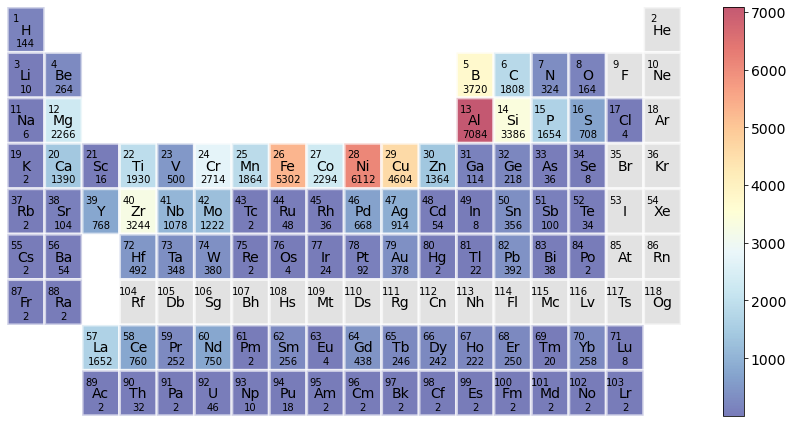

In [16]:
X, y , p = alt_read_gfa_dataset()
gfa_elem_count = get_elem_count(X)
periodic_table_heatmap(gfa_elem_count,blank_color='lightgrey',edge_color='white', value_format='%.0f',
                            cmap='RdYlBu_r',save_name = fig_location+'/gfa_elem_heatmap.pdf')

<module 'matplotlib.pyplot' from '/noether/s0/aqd5773/anaconda3/envs/representations/lib/python3.10/site-packages/matplotlib/pyplot.py'>

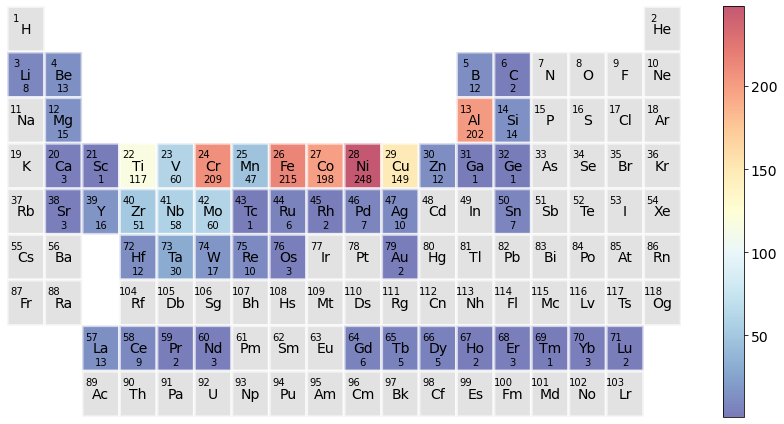

In [22]:
[x0,dataY]=pickle.load(open(phase_file_path, 'rb'))
comps = [y.split(' ')[1] for y in x0]
phase_elem_count = get_elem_count(comps)
periodic_table_heatmap(phase_elem_count,blank_color='lightgrey',edge_color='white', value_format='%.0f',
                            cmap='RdYlBu_r',save_name = fig_location+'/phase_elem_heatmap.pdf')

<module 'matplotlib.pyplot' from '/noether/s0/aqd5773/anaconda3/envs/representations/lib/python3.10/site-packages/matplotlib/pyplot.py'>

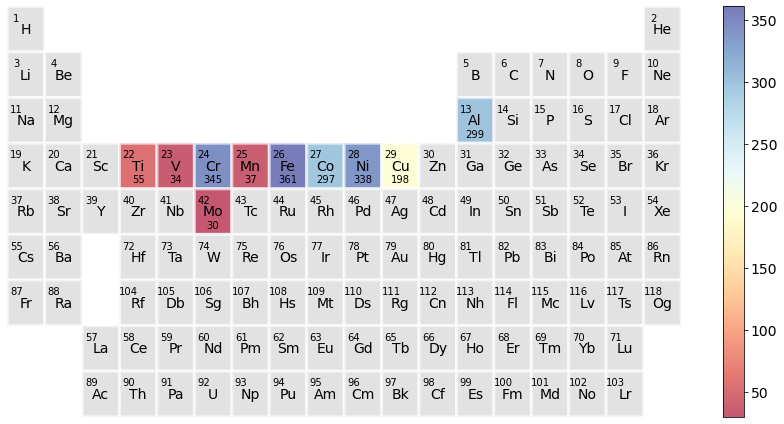

In [7]:
hardness_elem_count = get_elem_count(hardness_df['Composition'])
periodic_table_heatmap(hardness_elem_count,blank_color='lightgrey',edge_color='white', value_format='%.0f',
                            cmap='RdYlBu',save_name = fig_location+'/hardness_elem_heatmap.pdf')

<module 'matplotlib.pyplot' from '/noether/s0/aqd5773/anaconda3/envs/representations/lib/python3.10/site-packages/matplotlib/pyplot.py'>

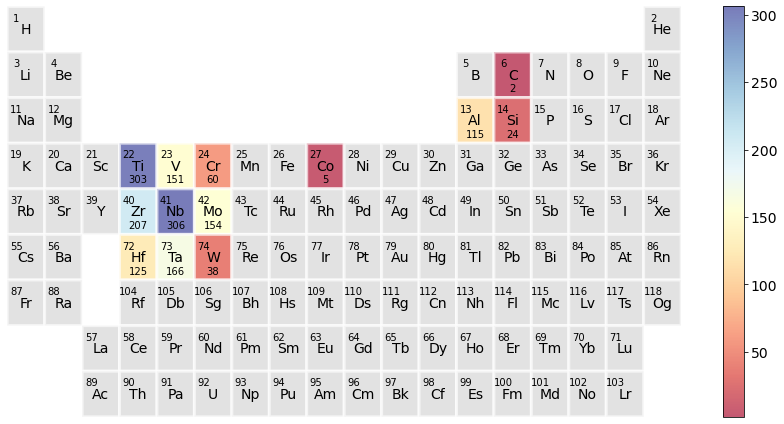

In [4]:
yield_elem_count = get_elem_count(yield_str_df['Composition'])
periodic_table_heatmap(yield_elem_count,blank_color='lightgrey',edge_color='white', value_format='%.0f',
                            cmap='RdYlBu',save_name = fig_location+'/yield_str_elem_heatmap.pdf')

#Distribution of property values

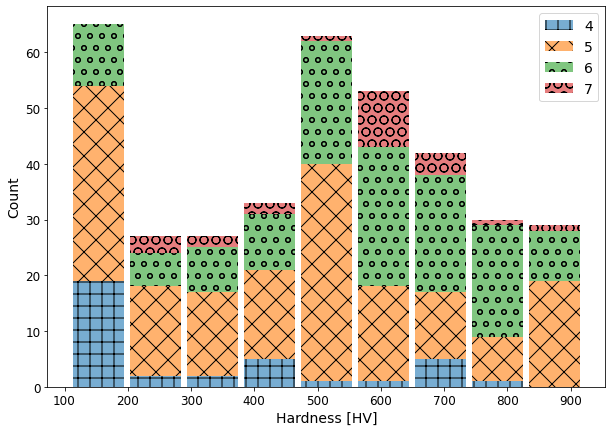

In [5]:
hardness_df['n_eles'] = get_number_of_components(hardness_df['Composition'])
min_eles = hardness_df['n_eles'].min()
max_eles = hardness_df['n_eles'].max()
slices = []
for i in np.arange(min_eles, max_eles+1):
    slices.append(hardness_df['HV'][hardness_df['n_eles']==i].values)

_,bins = get_comp_count_over_bins(hardness_df['HV'].values,10)

fig,ax = plt.subplots(figsize=(10,7))

n,bins,patches = plt.hist(slices,bins=bins-0.5,rwidth=0.9,stacked=True,alpha=0.6)

hatches = ['+', 'x', 'o', 'O', '.', '*','/', '\\', '|', '-', ]
for patch_set, hatch in zip(patches, hatches):
    for patch in patch_set.patches:
        patch.set_hatch(hatch)
#plt.yticks(np.arange(0,80,10),fontsize=12)
#plt.xticks(np.arange(100,1000,100),fontsize=12)
plt.legend(np.arange(min_eles, max_eles+1),fontsize=14)
plt.xlabel('Hardness [HV]',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(fig_location+'/hardness_dist.pdf',dpi=300)

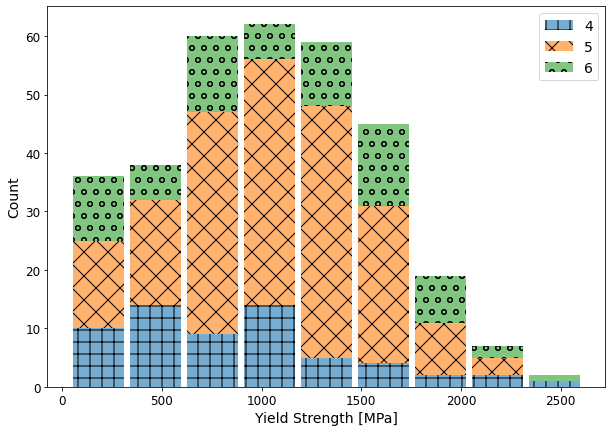

In [8]:
yield_str_df['n_eles'] = get_number_of_components(yield_str_df['Composition'])
min_eles = yield_str_df['n_eles'].min()
max_eles = yield_str_df['n_eles'].max()
slices = []
for i in np.arange(min_eles, max_eles+1):
    slices.append(yield_str_df['Yield Strength'][yield_str_df['n_eles']==i].values)

_,bins = get_comp_count_over_bins(yield_str_df['Yield Strength'].values,10)

fig,ax = plt.subplots(figsize=(10,7))

n,bins,patches = plt.hist(slices,bins=bins-0.5,rwidth=0.9,stacked=True,alpha=0.6)

hatches = ['+', 'x', 'o', 'O', '.', '*','/', '\\', '|', '-', ]
for patch_set, hatch in zip(patches, hatches):
    for patch in patch_set.patches:
        patch.set_hatch(hatch)
#plt.yticks(np.arange(0,80,10),fontsize=12)
#plt.xticks(np.arange(100,1000,100),fontsize=12)
plt.legend(np.arange(min_eles, max_eles+1),fontsize=14)
plt.xlabel('Yield Strength [MPa]',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(fig_location+'/yield_strength_dist.pdf',dpi=300)